In [34]:
# Load the tfa model 
from pytfa.io.json import load_json_model
model_file = 'reduced_model_ETC_core_20250228-213124_continuous.json'

tmodel = load_json_model(model_file)

2025-08-23 10:39:02,479 - thermomodel_Recon3thermoCurated - continuous - INFO - # Model initialized with units kcal/mol and temperature 298.15 K


In [35]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load the lumps.json file
with open('lumps.json', 'r') as f:
    lumps_data = json.load(f)

print("Available pathways in lumps.json:")
for key in lumps_data.keys():
    print(f"- {key}")

# Extract reactions from each pathway
def extract_reactions(pathway_data,tmodel):
    """Extract all unique reactions from a pathway"""
    reactions = set()
    for lump in pathway_data:
        if len(lump) >= 3:  # Ensure there's reaction data
            reaction_dict = lump[2]  # The third element contains reaction coefficients
            # Check if the reaction is in the model
            for reaction_id in reaction_dict.keys():
                if reaction_id in tmodel.reactions:
                    reactions.add(reaction_id)
                else:
                    print(f"Warning: Reaction {reaction_id} not found in the model.")

    return reactions

# Extract reactions for each pathway
#glucose_reactions = extract_reactions(lumps_data.get('EX_glc_D_e', [])) # Drop glycolysis only focus on oxidtion
glucose_ox_reactions = extract_reactions(lumps_data.get('EX_glc_D_e_ox', []), tmodel)
lactate_reactions = extract_reactions(lumps_data.get('EX_lac_L_e', []), tmodel)
bhb_reactions = extract_reactions(lumps_data.get('EX_bhb_e', []), tmodel)
fatty_acid_reactions = extract_reactions(lumps_data.get('EX_hdca_e', []), tmodel)

Available pathways in lumps.json:
- EX_hdca_e
- EX_glc_D_e_ox
- EX_glc_D_e
- EX_lac_L_e
- EX_bhb_e


In [36]:
# Lump where generated with the lactate shuttle in the core reactions 
lactate_reactions.update(['LDH_Lm','L_LACtm'])

In [37]:
# ADD Glycerol-3-phosphate shuttle and maltate-aspartate shuttle reactions to the glusose oxidation reactions
aspartate_malate_shuttle = ['MDH', 'ASPTA', 'ASPTAm', 'MDHm', 'ASPGLUm', 'AKGMALtm']
glycerol_3_phosphate_shuttle = ['G3PD1', 'r0205']
glucose_ox_reactions.update(aspartate_malate_shuttle)
glucose_ox_reactions.update(glycerol_3_phosphate_shuttle)

In [38]:
# Extract reactants from each pathway
def extract_reactants(pathway_data,tmodel):
    """Extract all unique reactants from a pathway"""
    metabolites = set()
    for lump in pathway_data:
        if len(lump) >= 3:  # Ensure there's reaction data
            reaction_dict = lump[2]  # The third element contains reaction coefficients
            # Get the reactants from the model
            reactions = list(reaction_dict.keys())
            this_metabolites = set()
            for r in reactions:
                # Get the reaction by ID from the tmodel
                if r in tmodel.reactions:
                    # Get the metabolites for this reaction
                    this_metabolites.update([m.id for m in tmodel.reactions.get_by_id(r).metabolites ])
            metabolites.update(this_metabolites)
    return metabolites

# Prepare the four oxidation pathway reactant sets
react_sets = {
    'Glucose': extract_reactants(lumps_data.get('EX_glc_D_e_ox', []), tmodel),
    'Lactate': extract_reactants(lumps_data.get('EX_lac_L_e', []), tmodel),
    '3HB': extract_reactants(lumps_data.get('EX_bhb_e', []), tmodel),
    'Fatty acids': extract_reactants(lumps_data.get('EX_hdca_e', []), tmodel)
}




In [39]:
# Prepare the four oxidation pathway sets
sets = {
    'Glucose': glucose_ox_reactions,
    'Lactate': lactate_reactions, 
    '3HB': bhb_reactions,
    'Fatty acids': fatty_acid_reactions
}

# Compute elasticity matrices

In [40]:
# Scaling parameters
CONCENTRATION_SCALING = 1e3 # 1 mol to 1 mmol
TIME_SCALING = 1 # 1min
DENSITY = 1200 # g/L 
GDW_GWW_RATIO = 1.0 # Fluxes are in gWW

# To test how close to zero the dxdt is
flux_scaling_factor = 1e-6 / (GDW_GWW_RATIO / DENSITY) \
                        * CONCENTRATION_SCALING \
                        / TIME_SCALING

In [41]:
# Load TFA samples 
import pandas as pd
import numpy as np
tfa_sample_file = 'reduced_model_ETC_core_20250228-213124_tfa_sampling.csv'
tfa_samples = pd.read_csv(tfa_sample_file)


faraday_const = 23.061 # kcal / mol / V
RT = tmodel.RT # kcal /mol
delta_psi_scaled = 150/1000 * faraday_const / RT  # mV * F / RT 

# Psuedo data for the membrane potential
tfa_samples['psi_m_c'] = delta_psi_scaled * 1e-3 # be aware of the scaling!!!
tfa_samples['MitoMembranePot_in'] = 1000 # ~ 1000 RT/min -> at 5 RT is equivalent to about 2 min time scale for the membrane potential
tfa_samples['MitoMembranePot_out'] = 1000

# 30 min timescale for insulin action 
tfa_samples['Insulin_secretion'] = 1/30 / flux_scaling_factor
tfa_samples['Insulin_degradation'] = 1/30 / flux_scaling_factor
tfa_samples['insulin_e'] = 1e-3 

additional_fluxes = ['MitoMembranePot_in','MitoMembranePot_out', 'Insulin_secretion', 'Insulin_degradation',]
additional_concentrations = ['psi_m_c', 'insulin_e']

## Detailed model with regulation

In [42]:
# Reload and prepare the model
from skimpy.io.yaml import load_yaml_model
from skimpy.utils.tabdict import TabDict

kmodel = load_yaml_model(model_file.replace("_continuous.json", "_kinetic_curated.yml"))

# Compile the ode expressions
NCPU = 12
kmodel.repair()
kmodel.prepare(mca=False)
kmodel.compile_mca(ncpu=NCPU)

In [43]:
# Load only the robust parameters samples
from skimpy.core.parameters import load_parameter_population
parameter_population = load_parameter_population(tfa_sample_file.replace(".csv",'_robust_parameters.hdf5'))


In [44]:
# Extract the 10 best parameter sets from the fuel competition results
best_fuel_competition_results = pd.read_csv('./output/fuel_competition_rep_parameter_sets.csv')
best_parameter_sets = best_fuel_competition_results['parameter_set'].unique().tolist()

In [45]:
from skimpy.core.parameters import ParameterValuePopulation
# Create a parameter population from the best parameter sets
list_best_parameter_sets_obj = [parameter_population[p] for p in best_parameter_sets]
parameter_population = ParameterValuePopulation(list_best_parameter_sets_obj, kmodel)

In [46]:
# Make the flux function
from skimpy.analysis.ode.utils import make_flux_fun
from skimpy.utils.namespace import QSSA

flux_function = make_flux_fun(kmodel, QSSA)

In [47]:
from tqdm import tqdm

from skimpy.core.parameters import ParameterValues
from skimpy.analysis.oracle import load_concentrations


def get_elasticities(kmodel, tfa_samples, params_population, end_ix=-1):
    """
    Calculate the independent and dependent elasticities for the given concentrations and parameters.
    
    Parameters:
    - kmodel: The kinetic model.
    - concentrations: A dictionary of concentrations.
    - params_population: A dictionary of parameters for the population.
    
    Returns:
    - Ei: DataFrame of independent elasticities.
    - Ed: DataFrame of dependent elasticities.
    """
    
    variables = list(kmodel.reactants.keys())
    flux_names = list(kmodel.reactions.keys())

    independent_variables = [variables[i] for i in kmodel.independent_variables_ix]
    dependent_variables = [variables[i] for i in kmodel.dependent_variables_ix]

    # List of dataframes
    results = []    
        

    # Run the perturbation for each parameterset
    parameter_population_index = list(parameter_population._index.keys())
    for parameter_set_id in tqdm(parameter_population_index[:end_ix]):

        thermo_index = int(parameter_set_id.split(',')[0])
        thermo_sample = tfa_samples.loc[thermo_index]

        concentrations = load_concentrations(thermo_sample, tmodel, kmodel, 
                                            concentration_scaling=CONCENTRATION_SCALING,
                                            additional_concentrations=additional_concentrations)

        # Order concentration like in model
        sorted_concentrations = concentrations[kmodel.variables.keys()]

        # Calculate independent and dependent elasticities
        Ei = kmodel.independent_elasticity_fun(sorted_concentrations, params_population[parameter_set_id])
        Ed = kmodel.dependent_elasticity_fun(sorted_concentrations, params_population[parameter_set_id])
        Ei = pd.DataFrame(Ei.todense(), columns = independent_variables, index = flux_names)
        Ed = pd.DataFrame(Ed.todense(), columns = dependent_variables, index = flux_names)
        # Combine the independent and dependent elasticities into a single DataFrame
        E = pd.concat([Ei, Ed], axis=1)

        results.append({
            'parameter_set': parameter_set_id,
            'elasticities': E,
        })

    return results



In [48]:
elasticity_results = get_elasticities(kmodel, tfa_samples, parameter_population, end_ix=10)

100%|██████████| 1/1 [00:00<00:00, 171.35it/s]


In [49]:
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list


def create_elasticity_heatmap(elasticity_results, metabolites=None, reactions=None, pathway_sets=None,
                               pathway_colors=None, figsize=(12, 8), min_max = None, custom_cmap='coolwarm',
                               reaction_annotations=None, metabolite_annotations=None, 
                               summarize_dictionary=None, row_order=None):
    """
    Create a heatmap of the median and CV of elasticities from the elasticity results.
    
    Parameters:
    - elasticity_results: List of dictionaries containing elasticity matrices.
    - metabolites: List of metabolites to include in the heatmap.
    - reactions: List of reactions to include in the heatmap.
    - pathway_sets: Dictionary of pathway names to reaction sets.
    - pathway_colors: Dictionary of pathway names to colors.
    - reaction_annotations: Dictionary mapping reaction IDs to human-readable names.
    - metabolite_annotations: Dictionary mapping metabolite IDs to human-readable names.
    - figsize: Size of the heatmap figure.
    - min_max: Tuple of (vmin, vmax) for the heatmap color scale
    - summarize_dictionary: Dictionary to summarize reactions into pathways.
    - row_order: List of reactions to order the heatmap by.

    Returns:
    - fig: The matplotlib figure object.
    - median_data: DataFrame of median elasticities.
    - cv_data: DataFrame of coefficient of variation (CV) of elasticities.
    """
    
    # Extract all elasticities into a single DataFrame
    all_elasticities = pd.concat([result['elasticities'] for result in elasticity_results], axis=0)
    
    # Calculate median and CV
    median_data = all_elasticities.groupby(level=0).median()
    cv_data = all_elasticities.groupby(level=0).std() / median_data
    
    # Filter by metabolites and reactions if provided
    if metabolites is not None:
        median_data = median_data.loc[reactions, metabolites]
        cv_data = cv_data.loc[reactions, metabolites]

    # Summarize the data across reactions if there is summarize_dictionary
    if summarize_dictionary is not None:
        # Replace the reaction elasticities in the values of the summarize_dictionary
        # in to a summed row 
        for pathway_name, reactions in summarize_dictionary.items():

            # Take the strongest (maximum absolute) effect across all reactions in the group
            summed_row = median_data.loc[reactions].abs().max()
            # Preserve the sign of the strongest effect for each metabolite
            for col in median_data.columns:
                abs_vals = median_data.loc[reactions, col].abs()
                idx_max = abs_vals.idxmax()
                summed_row[col] = median_data.loc[idx_max, col]

            median_data.loc[pathway_name] = summed_row
            median_data.drop(reactions, inplace=True)
            
            summed_cv_row = cv_data.loc[reactions].mean()
            cv_data.loc[pathway_name] = summed_cv_row
            cv_data.drop(reactions, inplace=True)
    
    # Filter reactions to only include annotated ones if annotations are provided
    if reaction_annotations is not None:
        # Only keep reactions that are in the annotation dictionary
        annotated_reactions = [r for r in median_data.index if r in reaction_annotations]
        median_data = median_data.loc[annotated_reactions]
        cv_data = cv_data.loc[annotated_reactions]
        
        # Rename the reaction index using annotations
        median_data.index = [reaction_annotations[r] for r in median_data.index]
        cv_data.index = [reaction_annotations[r] for r in cv_data.index]
    
    # Filter metabolites to only include annotated ones if annotations are provided
    if metabolite_annotations is not None:
        # Only keep metabolites that are in the annotation dictionary
        annotated_metabolites = [m for m in median_data.columns if m in metabolite_annotations]
        median_data = median_data[annotated_metabolites]
        cv_data = cv_data[annotated_metabolites]
        
        # Rename the metabolite columns using annotations
        median_data.columns = [metabolite_annotations[m] for m in median_data.columns]
        cv_data.columns = [metabolite_annotations[m] for m in cv_data.columns]

        # Reconile duplocate columns by suming them
        median_data = median_data.groupby(median_data.columns, axis=1).sum()
        cv_data = cv_data.groupby(cv_data.columns, axis=1).sum()
        

    # First pass: count pathway memberships
    # Create pathway mapping for colored indicators (if pathway info is provided)
    reaction_to_pathway = {}
    if pathway_sets is not None:
        pathway_order = ['Glucose', 'Lactate', '3HB', 'Fatty acids']
        
        # Need to work with original reaction IDs for pathway mapping
        original_reactions = []
        if reaction_annotations is not None:
            # Map back from annotated names to original IDs
            reverse_annotations = {v: k for k, v in reaction_annotations.items()}
            original_reactions = [reverse_annotations.get(r, r) for r in median_data.index]
        else:
            original_reactions = median_data.index.tolist()
            
        for i, reaction in enumerate(median_data.index):
            original_reaction = original_reactions[i]
            pathway_count = 0
            belonging_pathways = []
            for pathway_name in pathway_order:
                if pathway_name in pathway_sets and original_reaction in pathway_sets[pathway_name]:
                    pathway_count += 1
                    belonging_pathways.append(pathway_name)
            
            if pathway_count == 1:
                reaction_to_pathway[reaction] = belonging_pathways[0]
            elif pathway_count > 1:
                reaction_to_pathway[reaction] = 'Multiple'
            else:
                reaction_to_pathway[reaction] = 'Unknown'
    
    # Rank metabolites by the number of effects they have on each pathway
    if pathway_sets is not None:
        # Calculate the number of significant effects each metabolite has on each pathway
        metabolite_pathway_effects = {}
        significance_threshold = 0.1  # Threshold for considering an effect significant
        
        # Need to work with original reaction IDs for pathway mapping
        original_reactions = []
        if reaction_annotations is not None:
            # Map back from annotated names to original IDs
            reverse_annotations = {v: k for k, v in reaction_annotations.items()}
            original_reactions = [reverse_annotations.get(r, r) for r in median_data.index]
        else:
            original_reactions = median_data.index.tolist()
        
        pathway_order = ['Glucose', 'Lactate', '3HB', 'Fatty acids']
        
        for metabolite in median_data.columns:
            metabolite_pathway_effects[metabolite] = {}
            
            for pathway_name in pathway_order:
                if pathway_name in pathway_sets:
                    # Count significant effects for this metabolite on this pathway
                    pathway_effect_count = 0
                    for i, reaction in enumerate(median_data.index):
                        original_reaction = original_reactions[i]
                        if original_reaction in pathway_sets[pathway_name]:
                            # Check if the elasticity is significant
                            elasticity_value = abs(median_data.loc[reaction, metabolite])
                            if elasticity_value > significance_threshold:
                                pathway_effect_count += 1
                    
                    metabolite_pathway_effects[metabolite][pathway_name] = pathway_effect_count
        
        # Create a sorting key for metabolites based on pathway effects
        def metabolite_sort_key(metabolite):
            effects = metabolite_pathway_effects[metabolite]
            # Count number of pathways where this metabolite has effects (> 0)
            pathways_affected = sum(1 for count in effects.values() if count > 0)
            # Sort by number of pathways affected (descending), then by total effects, then by name
            total_effects = sum(effects.values())
            # Create a tuple for sorting: (negative pathways affected, negative total effects, metabolite name)
            return (-pathways_affected, -total_effects, metabolite)
        
        # Sort metabolites by their effects on pathways
        sorted_metabolites = sorted(median_data.columns, key=metabolite_sort_key)
        median_data = median_data[sorted_metabolites]
        cv_data = cv_data[sorted_metabolites]

        
        print(f"Metabolite ranking by number of pathways affected:")
        for metabolite in sorted_metabolites:
            effects = metabolite_pathway_effects[metabolite]
            total = sum(effects.values())
            pathways_affected = sum(1 for count in effects.values() if count > 0)
            pathway_breakdown = ", ".join([f"{pathway}: {count}" for pathway, count in effects.items()])
            print(f"  {metabolite}: Pathways={pathways_affected}, Total effects={total} ({pathway_breakdown})")
    else:
        # Fallback: sort alphabetically if no pathway information
        sorted_metabolites = sorted(median_data.columns)
        median_data = median_data[sorted_metabolites]
        cv_data = cv_data[sorted_metabolites]

    # Reorder the rows if row_order is provided 
    if row_order is not None:
        # Ensure row_order is a list of reactions that are in the median_data index
        row_order = [r for r in row_order if r in median_data.index]
        median_data = median_data.loc[row_order]
        cv_data = cv_data.loc[row_order]
    else:
        # If no specific order, use clustering to order rows
        Z = linkage(median_data, method='ward')
        ordered_indices = leaves_list(Z)
        median_data = median_data.iloc[ordered_indices]
        cv_data = cv_data.iloc[ordered_indices]
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=figsize)

    # Set vmin/vmax to 95, 5 
    median_data_flat = median_data.stack()
    median_data_flat = median_data_flat[median_data_flat.abs() > 0.0]  # Filter out small values
    vmin = median_data_flat.quantile(0.05)
    vmax = median_data_flat.quantile(0.95)
    
    if min_max is None:
        print(f"vmin: {vmin}, vmax: {vmax}")
        # Makt vmin and vmax more symmetric
        vmin = max(abs(vmin), abs(vmax)) * -1
        vmax = max(abs(vmin), abs(vmax))
    else:
        vmin, vmax = min_max
        # Ensure vmin and vmax are symmetric around zero
        vmin = -max(abs(vmin), abs(vmax))
        vmax = max(abs(vmin), abs(vmax))

    # Create the heatmap first
    im = sns.heatmap(median_data, ax=ax, cmap=custom_cmap,
                cbar_kws={'shrink': 0.5, 'aspect': 20, 
                         'anchor': (0.0, 0.9),},
                linewidths=0.5, linecolor='grey', center=0, 
                vmin=vmin, vmax=vmax,
                )
    
    
    # Add colored indicators for pathways after the heatmap
    if pathway_sets is not None and pathway_colors is not None:
        # Get the current axis limits
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        ()
        
        # Create colored bars on the left side to indicate pathway membership
        bar_width = 0.5
        bar_x = xlim[0] - 0.6  # Position to the left of the heatmap
        
        # Add a color for multiple pathway reactions
        multiple_pathway_color = "#B86F3B"  # Brown color for multiple pathways
        
        for i, reaction in enumerate(median_data.index):
            pathway = reaction_to_pathway.get(reaction, 'Unknown')
            
            if pathway == 'Multiple':
                # Special color for reactions in multiple pathways
                rect = plt.Rectangle((bar_x, i), bar_width, 1, 
                                   facecolor=multiple_pathway_color, 
                                   edgecolor='black', linewidth=0.5, alpha=0.8,
                                   clip_on=False)
                ax.add_patch(rect)
            elif pathway in pathway_colors:
                # Regular pathway color
                rect = plt.Rectangle((bar_x, i), bar_width, 1, 
                                   facecolor=pathway_colors[pathway], 
                                   edgecolor='black', linewidth=0.5, alpha=0.8,
                                   clip_on=False)
                ax.add_patch(rect)
        
        # Extend the x-axis to show the colored bars
        ax.set_xlim(xlim[0] - 0.65, xlim[1]+0.1)
        # Adjust the y-axis limits to fit the colored bars
        ax.set_ylim(ylim[0] + 0.05, ylim[1])         
        # Add legend for pathway colors including multiple pathways
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=multiple_pathway_color, label='Multiple pathways')]
        legend_elements.extend([Patch(facecolor=color, label=pathway) 
                              for pathway, color in pathway_colors.items()])
        ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1., 0.3), 
                 title='Pathway', fontsize='small', title_fontsize='medium', frameon=False)
    else:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(xlim[0] - 0.05, xlim[1]+0.1)
        ax.set_ylim(ylim[0] + 0.01, ylim[1])
    
    
    # Modify colorbar to show >= vmax and <= vmin labels
    cbar = im.collections[0].colorbar
    
    # Set the colorbar label on top and horizontal
    cbar.set_label('Elasticity', rotation=0, labelpad=15)
    cbar.ax.xaxis.set_label_position('top')
    
    # Get current tick locations and labels
    tick_locs = cbar.get_ticks()
    tick_labels = [f'{tick:.1f}' for tick in tick_locs]
    
    # Replace the extreme values with inequality signs
    if len(tick_labels) > 0:
        tick_labels[0] = f'≤ {vmin:.1f}'  # Minimum value
        tick_labels[-1] = f'≥ {vmax:.1f}'  # Maximum value
    
    # Set the modified labels
    cbar.set_ticklabels(tick_labels)

    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')

    
    return fig, median_data, cv_data

In [50]:
common_reactants = list(set.intersection(*react_sets.values()))
common_reactions = set.intersection(*sets.values())
uncommon_reactions = list(set.union(*sets.values()) - common_reactions)

In [51]:
# Check if these are in the kinetic model (since we drop water and set some constant)
common_reactants_filtered = [r for r in common_reactants if r in kmodel.reactants]

In [52]:
# Exclude metabolites that are not seen as  metabolites
excluded_metabolites = ['h2o_c','h_m','h_c', 'o2_m', 'o2_c', 'co2_m', 'co2_c', 'pi_c', 'pi_m']

common_reactants_filtered = [r for r in common_reactants_filtered if r not in excluded_metabolites]

In [53]:
# Add a color for each pathway - distinct, high-contrast, colorblind-friendly palette
pathway_colors = {
    'Glucose': '#2E74B5',    # Medium blue
    'Lactate': '#595959',   # Medium gray  
    '3HB': '#DAA520',       # Goldenrod
    'Fatty acids': '#7A6BB5',  # Muted blue violet
}


In [54]:
# Red-green colormap: red for negative, white center, green for positive
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


In [55]:
# Colorblind-friendly alternative: blue-white-orange colormap
n_bins = 256
# Blue for negative, white center, orange for positive - distinguishable by all color vision types
colorblind_colors = ['#2166ac', '#67a9cf', '#ffffff', '#fdbf6f', '#e66101'] # Blue to white to orange
colorblind_cmap = mcolors.LinearSegmentedColormap.from_list('colorblind_friendly', colorblind_colors, N=n_bins)

# Set the colorblind-friendly colormap as default
vlag_colorblind = colorblind_cmap

In [56]:
# Summary dictionary for reaction annotations
summary_dict = {
    'MalAsp': aspartate_malate_shuttle,
    'G3PS': glycerol_3_phosphate_shuttle,
}

In [57]:
# Comprehensive flux variable annotation dictionary covering all reactions in the reduced model
flux_variable_annotation_dict = {
    # Central metabolic enzymes
    'MalAsp':'Mal/Asp shuttle',
    'G3PS': 'G3P shuttle',
    'PDHm': 'PDH',
    'CSm': 'CS',
    'ACONTm': 'ACON',
    'ICDHxm': 'ICDH',
    'AKGDm': 'AKGDH',
    'SUCOAS1m': 'SUCOAS1',
    'r0509': 'SDH',
    'FUMm': 'FUM',
    'MDHm': 'MDH',
    'ASPTAm': 'ASPTA[m]',
    
    # Glycolysis
    'HEX1': 'HEX',
    'PGI': 'PGI',
    'PFK': 'PFK',
    'FBA': 'ALDA',
    'TPI': 'TPI',
    'GAPD': 'GAPDH',
    'PGK': 'PGK',
    'PGM': 'PGM',
    'ENO': 'ENO',
    'PYK': 'PYK',
    'LDH_L': 'LDH',
    'LDH_Lm': 'LDH[m]',
    
    # Fatty acid oxidation
    'FACOAL160i': 'ACLS',
    'C160CPT1': 'CPT1',
    'C160CPT2': 'CPT2',
    'FAOXC160': 'β-oxidation',
    
    # Ketone metabolism
    'BDHm': 'BDH',
    'OCOAT1m': 'SCOT',
    'ACACT1rm': 'Thiolase',
    
    # Electron transport chain
    'NADH2_u10mi': 'Complex I',
    'FADH2ETC': 'Complex II',
    'CYOR_u10mi': 'Complex III',
    'CYOOm2i': 'Complex IV ',
    'ATPS4mi': 'ATP synthase',
    
    # Transporters
    'GLCt1r': 'GLUT1/4',
    #'L_LACt2r': 'MCT',
    #'L_LACtm': 'MCT',
    'HDCAtr': 'CD36',
    #'BHBt': 'MCT',
    #'BHBtm': 'MCT',
    'PYRt2m': 'MPC',
    'ATPtm': 'ATP/ADP translocator',
    'PiC': 'Phosphate carrier',
    # 'O2t': 'Oxygen transporter (extracellular)',
    # 'O2tm': 'Oxygen transporter (mit)',
    # 'CO2t': 'CO2 transporter (extracellular)',
    # 'CO2tm': 'CO2 transporter (mit)',
    
    # Other important enzymes
    'ADK1': 'ADK',
    'NDPK1m': 'Nucleoside diphosphate kinase',
    'G3PD1': 'GPD1',
    'MDH': 'MDH[c]',
    'ASPTA': 'ASPTA',
    'ASPGLUm': 'SLC25A12',
    'AKGMALtm': 'SLC25A11',
    #'PPA': 'PPA',
    
    # ATP utilization and other reactions
    #'c_atp2adp': 'c ATP utilization',
    #'atp2amp_c': 'ATP to AMP conversion',
    'r0205': 'GPD2',
    'r2435': 'OCTN2',
    #'The': 'Thermogenesis/proton leak',
    # 'MitoMembranePot_in': 'mit membrane potential'
}

print(f"Flux annotation dictionary contains {len(flux_variable_annotation_dict)} reactions")

Flux annotation dictionary contains 50 reactions


In [58]:
# Dictionary mapping variable names to descriptive biochemical annotations
variable_annotation_dict = {
    'coa_m': 'CoA',
    'aacoa_m': 'Acetoacetyl-CoA',
    'accoa_m': 'Acetyl-CoA',
    'icit_m': 'Isocitrate',
    'cit_m': 'Citrate',
    'adp_c': 'ADP',
    'atp_c': 'ATP',
    'amp_c': 'AMP',
    'h_c': 'Proton',
    'succoa_m': 'Succinyl-CoA',
    'nadh_m': 'NADH',
    'co2_m': 'CO2',
    'nad_m': 'NAD+',
    'akg_m': 'α-Ketoglutarate',
    'mal_L_m': 'Malate',
    'akg_c': 'α-Ketoglutarate',
    'mal_L_c': 'Malate',
    'glu_L_m': 'Glutamate',
    
    'asp_L_c': 'Aspartate',
    'glu_L_c': 'Glutamate',
    'asp_L_m': 'Aspartate',
    'h_m': 'Proton',
    'psi_m_c': 'Membrane potential',
    'oaa_c': 'Oxaloacetate',
    'oaa_m': 'Oxaloacetate',
    'atp_m': 'ATP',
    'pi_m': 'Phosphate',
    'adp_m': 'ADP',
    'acac_m': 'Acetoacetate',
    'bhb_m': '3-HB',
    'bhb_c': '3-HB',
    'pmtcrn_c': 'Palmitoyl-Crn',
    'coa_c': 'Coenzyme A',
    'pmtcoa_c': 'Palmitoyl-CoA',
    'crn_c': 'Carnitine',
    'pmtcoa_m': 'Palmitoyl-CoA',
    'crn_m': 'Carnitine',
    'pmtcrn_m': 'Palmitoyl-Crn',
    'co2_c': 'CO2',
    'ficytC_m': 'Cytochrome c (reduced, mito)',
    'o2_m': 'O₂',
    'focytC_m': 'Cytochrome c (oxidized, mito)',
    'q10_m': 'Coenzyme Q10',
    'q10h2_m': 'Coenzyme Q10H₂',
    'pep_c': 'Phosphoenolpyruvate',
    '_2pg_c': '2-Phosphoglycerate',
    'ppi_c': 'Pyrophosphate',
    'hdca_c': 'Palmitate',
    'fad_m': 'FAD',
    'fadh2_m': 'FADH2',
    'g3p_c': 'Glycerol-3-phosphate',
    'dhap_c': 'Dihydroxyacetone phosphate',
    'fdp_c': 'Fructose-1,6-bisphosphate',
    'fum_m': 'Fumarate',
    'nadh_c': 'NADH',
    'nad_c': 'NAD+',
    'glyc3p_c': 'Glyceraldehyde-3-phosphate',
    '_13dpg_c': '1,3-Bisphosphoglycerate',
    'glc_D_c': 'Glucose',
    'g6p_c': 'Glucose-6-phosphate',
    'pyr_c': 'Pyruvate',
    'lac_L_c': 'Lactate',
    'pyr_m': 'Pyruvate',
    'lac_L_m': 'Lactate',
    'gtp_m': 'GTP',
    'gdp_m': 'GDP',
    'o2_c': 'O2',
    'succ_m': 'Succinate',
    'f6p_c': 'Fructose-6-phosphate',
    '_3pg_c': '3-Phosphoglycerate'
}

In [59]:
# Add malate-aspartate shuttle and glycerol-3-phosphate shuttle entries to glucose oxidation
sets['Glucose'].update(['MalAsp', 'G3PS'])

In [60]:
# We do a manual grouping to better comnunicate the results
row_order = [
   'β-oxidation', 'PDH', 'LDH[m]', 'BDH', 'Mal/Asp shuttle', # Nadh group
   'CPT2', 'Thiolase', # Coa group
   'ADK', 'PGK','PYK', 'PFK', 'HEX', 'ACLS',
   'SCOT', #
   'OCTN2','CPT1','CD36',
   'ENO', 'GAPDH', 'ALDA', 'TPI','PGI','GLUT1/4',
]

# Sort in reverse order
row_order = row_order[::-1]

Metabolite ranking by number of pathways affected:
  NAD+: Pathways=4, Total effects=6 (Glucose: 2, Lactate: 2, 3HB: 1, Fatty acids: 1)
  NADH: Pathways=4, Total effects=6 (Glucose: 2, Lactate: 2, 3HB: 1, Fatty acids: 1)
  CoA: Pathways=4, Total effects=5 (Glucose: 1, Lactate: 1, 3HB: 1, Fatty acids: 2)
  ATP: Pathways=3, Total effects=8 (Glucose: 5, Lactate: 1, 3HB: 0, Fatty acids: 2)
  ADP: Pathways=3, Total effects=7 (Glucose: 5, Lactate: 1, 3HB: 0, Fatty acids: 1)
  Acetyl-CoA: Pathways=2, Total effects=2 (Glucose: 1, Lactate: 1, 3HB: 0, Fatty acids: 0)
  Citrate: Pathways=1, Total effects=1 (Glucose: 1, Lactate: 0, 3HB: 0, Fatty acids: 0)
  Malate: Pathways=1, Total effects=1 (Glucose: 1, Lactate: 0, 3HB: 0, Fatty acids: 0)
  Oxaloacetate: Pathways=1, Total effects=1 (Glucose: 1, Lactate: 0, 3HB: 0, Fatty acids: 0)
  Succinate: Pathways=1, Total effects=1 (Glucose: 0, Lactate: 0, 3HB: 1, Fatty acids: 0)
  Succinyl-CoA: Pathways=1, Total effects=1 (Glucose: 0, Lactate: 0, 3HB: 1, F

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_58020/3681552102.py:295: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(tick_labels)


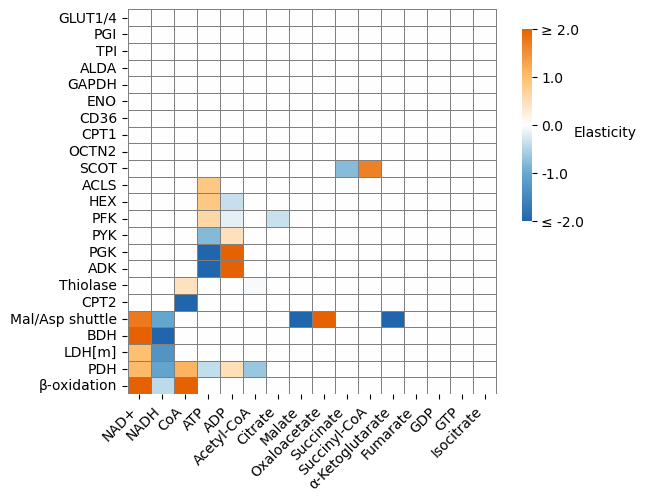

In [61]:
# Create the heatmap
fig, median_data, cv_data = create_elasticity_heatmap(elasticity_results, 
                                                     metabolites=common_reactants_filtered, 
                                                     reactions=uncommon_reactions,
                                                     pathway_sets=sets,
                                                     pathway_colors=None,
                                                     min_max=(-2,2),    
                                                     figsize=(6, 5), 
                                                     custom_cmap=colorblind_cmap,
                                                     reaction_annotations=flux_variable_annotation_dict,
                                                     metabolite_annotations=variable_annotation_dict,
                                                     summarize_dictionary=summary_dict, 
                                                     row_order=row_order,
                                                )
                                                    

plt.savefig('./output/elasticity_heatmap_clustered.svg', bbox_inches='tight')
plt.show()

/var/folders/n5/kq0k2frx06l30kyysqmgk1lw0000gn/T/ipykernel_58020/3548554412.py:126: UserWarning: FixedFormatter should only be used together with FixedLocator
  cbar.set_ticklabels(tick_labels)


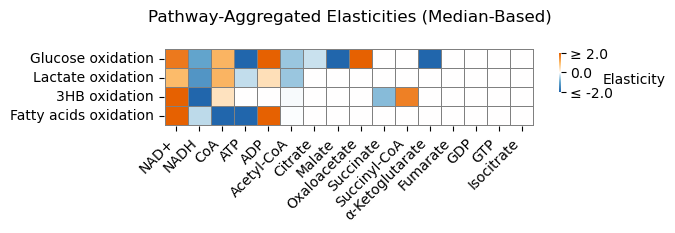

In [62]:
# Create aggregated heatmap based on median data
def create_median_based_aggregated_heatmap(median_data, pathway_sets, pathway_colors=None, 
                                          figsize=(8, 6), custom_cmap='coolwarm', min_max=None):
    """
    Create an aggregated heatmap based on median elasticity data.
    
    Parameters:
    - median_data: DataFrame of median elasticities from previous analysis
    - pathway_sets: Dictionary of pathway names to reaction sets
    - pathway_colors: Dictionary of pathway names to colors
    - figsize: Size of the heatmap figure
    - custom_cmap: Colormap to use
    - min_max: Tuple of (vmin, vmax) for the heatmap color scale
    
    Returns:
    - fig: The matplotlib figure object
    - aggregated_data: DataFrame of aggregated pathway elasticities
    """
    
    # Create a reverse mapping from reaction annotations back to original IDs
    reverse_flux_annotations = {v: k for k, v in flux_variable_annotation_dict.items()}
    
    # Initialize aggregated data dictionary
    pathway_elasticities = {}
    
    # For each pathway, aggregate the median elasticities
    for pathway_name, reaction_set in pathway_sets.items():
        pathway_elasticities[pathway_name] = []
        
        # Get reactions that are both in the pathway and in our median_data
        pathway_reactions_in_data = []
        for reaction in median_data.index:
            # Map back to original reaction ID if it was annotated
            original_reaction = reverse_flux_annotations.get(reaction, reaction)
            if original_reaction in reaction_set:
                pathway_reactions_in_data.append(reaction)
        
        if pathway_reactions_in_data:
            # For each metabolite, take the median of absolute values, preserving sign of strongest effect
            pathway_row = {}
            for metabolite in median_data.columns:
                pathway_effects = median_data.loc[pathway_reactions_in_data, metabolite]
                
                # Find the reaction with the strongest (maximum absolute) effect
                abs_effects = pathway_effects.abs()
                if abs_effects.max() > 0:
                    strongest_idx = abs_effects.idxmax()
                    # Use the original sign of the strongest effect
                    pathway_row[metabolite] = median_data.loc[strongest_idx, metabolite]
                else:
                    pathway_row[metabolite] = 0.0
            
            pathway_elasticities[pathway_name] = pathway_row
    
    # Convert to DataFrame
    aggregated_data = pd.DataFrame(pathway_elasticities).T
    
    # Ensure we have the same metabolites as the original data
    aggregated_data = aggregated_data[median_data.columns]
    
    # Create the heatmap
    fig, ax = plt.subplots(figsize=figsize)
    
    # Set color scale
    if min_max is None:
        # Use the same approach as before
        data_flat = aggregated_data.stack()
        data_flat = data_flat[data_flat.abs() > 0.0]
        vmin = data_flat.quantile(0.05)
        vmax = data_flat.quantile(0.95)
        vmin = -max(abs(vmin), abs(vmax))
        vmax = max(abs(vmin), abs(vmax))
    else:
        vmin, vmax = min_max
        vmin = -max(abs(vmin), abs(vmax))
        vmax = max(abs(vmin), abs(vmax))
    
    # Create heatmap
    im = sns.heatmap(aggregated_data, ax=ax, cmap=custom_cmap,
                     cbar_kws={'shrink': 0.5, 'aspect': 20, 'anchor': (0.0, 0.9)},
                     linewidths=0.5, linecolor='grey', center=0, 
                     vmin=vmin, vmax=vmax)
    
    # Add pathway colors if provided
    if pathway_colors is not None:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        
        bar_width = 0.5
        bar_x = xlim[0] - 0.6
        
        for i, pathway in enumerate(aggregated_data.index):
            if pathway in pathway_colors:
                rect = plt.Rectangle((bar_x, i), bar_width, 1, 
                                   facecolor=pathway_colors[pathway], 
                                   edgecolor='black', linewidth=0.5, alpha=0.8,
                                   clip_on=False)
                ax.add_patch(rect)
        
        # Extend x-axis and add legend
        ax.set_xlim(xlim[0] - 0.65, xlim[1] + 0.1)
        ax.set_ylim(ylim[0] + 0.05, ylim[1])
        
        from matplotlib.patches import Patch
        legend_elements = [Patch(facecolor=color, label=pathway) 
                          for pathway, color in pathway_colors.items()]
        ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1., 0.3), 
                 title='Pathway', fontsize='small', title_fontsize='medium', frameon=False)
    else:
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(xlim[0] - 0.05, xlim[1] + 0.1)
        ax.set_ylim(ylim[0] + 0.05, ylim[1])
    
    # Format colorbar
    cbar = im.collections[0].colorbar
    cbar.set_label('Elasticity', rotation=0, labelpad=15)
    cbar.ax.xaxis.set_label_position('top')
    
    # Set colorbar tick labels with inequality signs
    tick_locs = cbar.get_ticks()
    tick_labels = [f'{tick:.1f}' for tick in tick_locs]
    if len(tick_labels) > 0:
        tick_labels[0] = f'≤ {vmin:.1f}'
        tick_labels[-1] = f'≥ {vmax:.1f}'
    cbar.set_ticklabels(tick_labels)
    
    # Rotate x-axis labels
    plt.xticks(rotation=45, ha='right')
    
    plt.title('Pathway-Aggregated Elasticities (Median-Based)', pad=20)
    
    return fig, aggregated_data

# Create the aggregated heatmap
# Rename the keys to indicate pathways
sets = {k+" oxidation": v for k, v in sets.items() if k in ['Glucose', 'Lactate', '3HB', 'Fatty acids']}

fig_agg, pathway_elasticities = create_median_based_aggregated_heatmap(
    median_data, 
    sets, 
    pathway_colors=None,
    figsize=(6, 1),
    custom_cmap=colorblind_cmap,
    min_max=(-2, 2)
)

plt.savefig('./output/elasticity_heatmap_median_aggregated.svg', bbox_inches='tight')
plt.show()

